# Dealing with Outliers

How to deal with outliers?

The selection of the right approach in dealing with outliers must be informed from analytic goals and analytic tools.(See Figure below). in most situations, the way to deal with outliers is using a DO NOTHING approach.


There four approaches we can use to deal with outliers:

* Do nothing
* Replace with the upper cap or lower cap
* Perform a log transformation
* Remove data objects with outliers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Importing data

In [3]:
column_df = pd.read_csv('columns.csv')
response_df = pd.read_csv('responses.csv')

# First approach - Do Nothing

do nothing is the best strategy in most analytic situations. The reason for this is that most analytic tools we use can easily handle outliers.

In fact, if you know the analytic tools you want to use can handle outliers, you might not perform outlier detection in the first place. However, outlier detection itself may be the analytic you need, or the analytic tool you need to use is prone to outliers.



The table shown in the following screenshot lists some analytic tools/goals and specifies the best approach for dealing with outliers:

<img src="Dealing with outliers.png">

# Second approach - Replace with the upper cap or lower cap

Applying this approach may be wise when the following criteria are met: 

* The outlier is univariate. 
* The analytic goals and/or tools are sensitive to outliers. 
* We do not want to lose information by removing data objects. 
* An abrupt change of value will not lead to a significant change in the analytic conclusions.

We replace the univariate outliers that are too much smaller than the rest of the data object with the lower cap of the *Q1-1.5 * IQR* attribute, and replace the univariate outliers that are too much larger than the rest of the data objects with the upper cap of the *Q3+1.5 * IQR* attribute.


# Third approach – Perform a log transformation


As a method to deal with outlier detection, it is only applicable in certain situations. When an attribute follows an exponential distribution, it is only typical for some of the data objects to be very different from the rest of the population. In those situations, applying a log transformation will be the best approach.


# Fourth approach – Remove data objects with outliers

When the other methods are not helpful or possible, we may be reduced to removing the data objects with the outliers. This is our least favorite approach and should only be used

when absolutely necessary. The reason that we would like to avoid this approach is that the data is not incorrect; the values of the outliers are correct but happen to be too different from the rest of the population. It is our analytic tool that is incapable of dealing with the actual population.


# PAY ATTENTION!

*Pay Attention! As to when and whether you should adopt the approach of removing data objects due to being outliers, I would like to share with you an important word of advice. First, only apply this approach to the preprocessed version of the dataset that you've created for the specific analysis and not to the source data. The fact that this analysis needed the data objects with outliers to be removed does not mean all the analysis will need that. Second, make it a priority to inform the audience of the resulting analytic as they will be aware of this invasive approach in dealing with outliers.*

## Example 1 : Dealing with outliers when performing a linear regression

Capture the relationship between Height, Weight, and Gender to predict weight

weight = beta0 + Beta1* Height + Beta2 * Gender

we will go over the following steps, one by one: 
1. Dealing with missing values 
2. Detecting univariate outliers and dealing with them 
3. Detecting bivariate outliers and dealing with them 
4. Detecting multivariate outliers and dealing with them


### Diagnosing missing values in Weight, Height, and Gender

In [90]:
select_attributes = ['Weight', 'Height', 'Gender']
pre_process_df = pd.DataFrame(response_df[select_attributes])
pre_process_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  990 non-null    float64
 1   Height  990 non-null    float64
 2   Gender  1004 non-null   object 
dtypes: float64(2), object(1)
memory usage: 23.8+ KB


In [91]:
# get the number of missing values in each colum,

for col in select_attributes:
    MV_col = sum(pre_process_df[col].isna())
    percentage = round(MV_col/len(pre_process_df) * 100,2)
    print(f'missing values in {col}: {MV_col}, percentage missing: {percentage}%')

missing values in Weight: 20, percentage missing: 1.98%
missing values in Height: 20, percentage missing: 1.98%
missing values in Gender: 6, percentage missing: 0.59%


<AxesSubplot:>

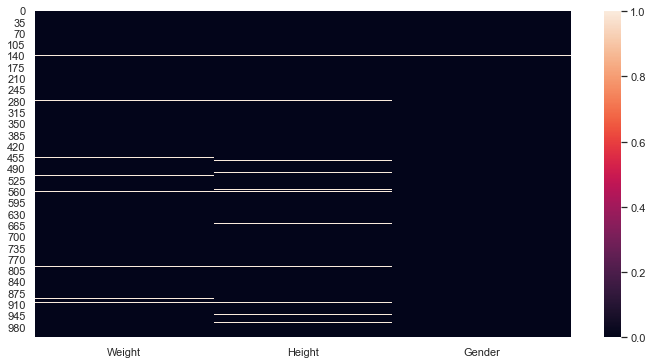

In [92]:
plt.figure(figsize=(12,6))
sns.heatmap(pre_process_df.isna())

for the majority of data objects, The missing values are not missing across the same data object.


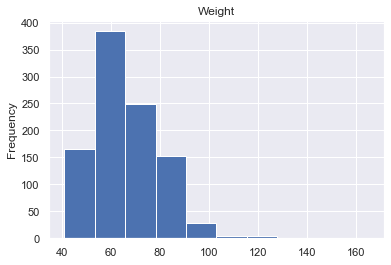

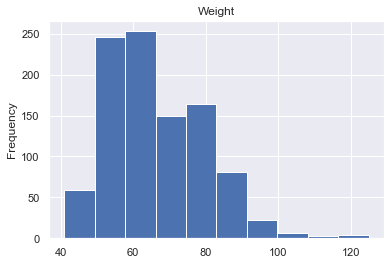

-------------------Divider-------------------------------


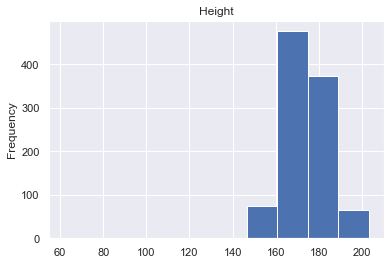

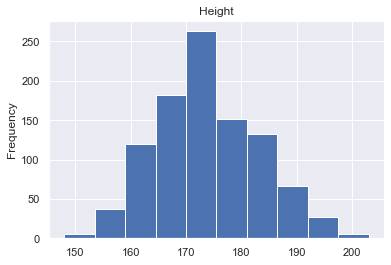

-------------------Divider-------------------------------


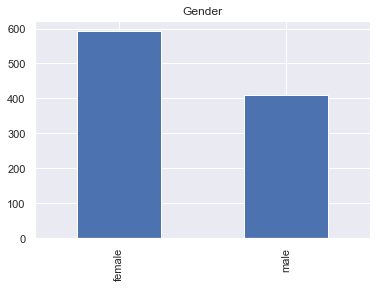

In [93]:
# distribution of weight, height, gender


response_df.Weight.plot.hist()
plt.title('Weight')
plt.show()
BM = response_df.Weight < 140
response_df.Weight[BM].plot.hist()
plt.title('Weight')
plt.show()

print('-------------------Divider-------------------------------')

response_df.Height.plot.hist()
plt.title('Height')
plt.show()
BM = response_df.Height > 140
response_df.Height[BM].plot.hist()
plt.title('Height')
plt.show()

print('-------------------Divider-------------------------------')

response_df.Gender.value_counts().plot.bar()
plt.title('Gender')
plt.show()

In [94]:
# Writing a function to diagnose the missing values both visually and statistically (numerical attrbiutes)
from scipy.stats import ttest_ind
def Diagnose_MV_Numerical(df,str_att_name,BM_MV):
    MV_labels = {True:'With Missing Values',False:'Without Missing Values'}
    
    labels=[]
    box_sr = pd.Series('',index = BM_MV.unique())    
    for poss in BM_MV.unique():
        BM = BM_MV == poss
        box_sr[poss] = df[BM][str_att_name].dropna()
        labels.append(MV_labels[poss])
   
    plt.boxplot(box_sr,vert=False)
    plt.yticks([1,2],labels)
    plt.xlabel(str_att_name)
    plt.show()
    
    plt.figure(figsize=(10,4))
    
    att_range = (df[str_att_name].min(),df[str_att_name].max())

    for i,poss in enumerate(BM_MV.unique()):
        plt.subplot(1,2,i+1)
        BM = BM_MV == poss
        df[BM][str_att_name].hist()
        plt.xlim = att_range
        plt.xlabel(str_att_name)
        plt.title(MV_labels[poss])

    plt.show()
    
    group_1_data = df[BM_MV][str_att_name].dropna()
    group_2_data = df[~BM_MV][str_att_name].dropna()
    
    p_value = ttest_ind(group_1_data,group_2_data).pvalue
    
    print('p-value of t-test: {}'.format(p_value))
    
    
from scipy.stats import chi2_contingency
def Diagnose_MV_Categorical(df,str_att_name,BM_MV):
    MV_labels = {True:'With Missing Values',False:'Without Missing Values'}

    plt.figure(figsize=(14,6))
    for i,poss in enumerate(BM_MV.unique()):
        plt.subplot(1,2,i+1)
        BM = BM_MV == poss
        df[BM][str_att_name].value_counts().plot.bar()
        plt.title(MV_labels[poss])
    plt.show()

    contigency_table = pd.crosstab(BM_MV,df[str_att_name])   
    p_value = chi2_contingency(contigency_table)[1]
    
    print('p-value of Chi_squared test: {}'.format(p_value))

In [95]:
pre_process_df.columns

Index(['Weight', 'Height', 'Gender'], dtype='object')

Diagnosis Analysis of Missing Values for Height:


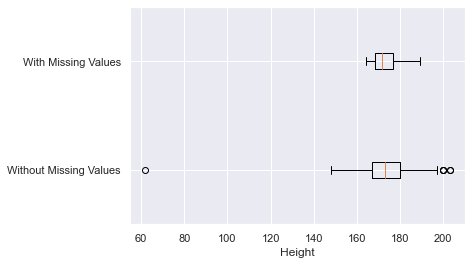

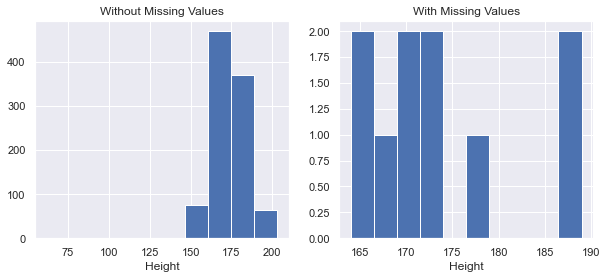

p-value of t-test: 0.9530447435441786
- - - - - - - - - - - - divider - - - - - - - - - - - 
Diagnosis Analysis of Missing Values for Gender:


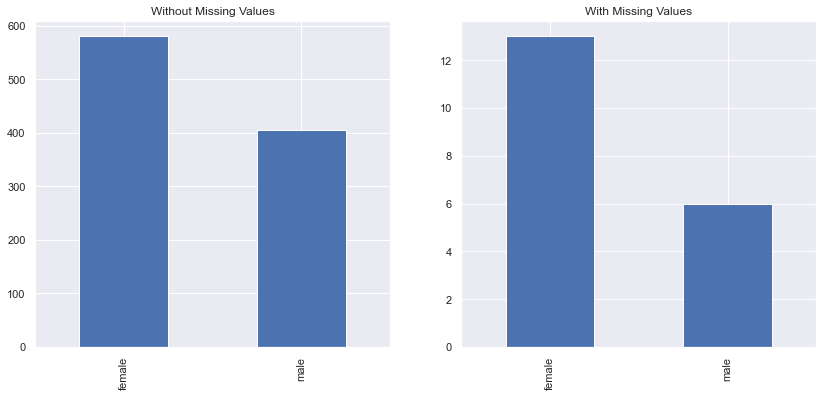

p-value of Chi_squared test: 0.5472167199163878
- - - - - - - - - - - - divider - - - - - - - - - - - 


In [96]:

#Get the numerical attrbiutes from air_df
numerical_attributes = ['Height']
categorical_attributes = ['Gender']
# create the boolean mask of missing values 
BM_MV = pre_process_df.Weight.isna()
# loop through each numerical attribute and run the Diagnose_MV_Numerical()
for att in numerical_attributes:
    print('Diagnosis Analysis of Missing Values for {}:'.format(att))
    Diagnose_MV_Numerical(pre_process_df,att,BM_MV)
    print('- - - - - - - - - - - - divider - - - - - - - - - - - ')
    
for att in categorical_attributes:
    print('Diagnosis Analysis of Missing Values for {}:'.format(att))
    Diagnose_MV_Categorical(pre_process_df,att,BM_MV)
    print('- - - - - - - - - - - - divider - - - - - - - - - - - ')

Diagnosis Analysis of Missing Values for Weight:


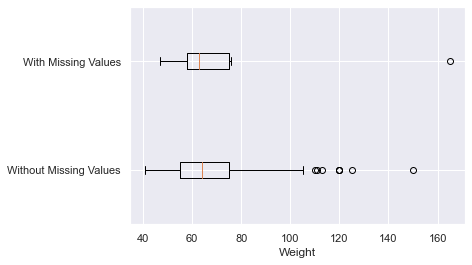

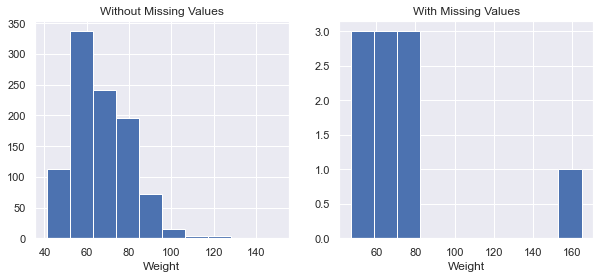

p-value of t-test: 0.12421884363635667
- - - - - - - - - - - - divider - - - - - - - - - - - 
Diagnosis Analysis of Missing Values for Gender:


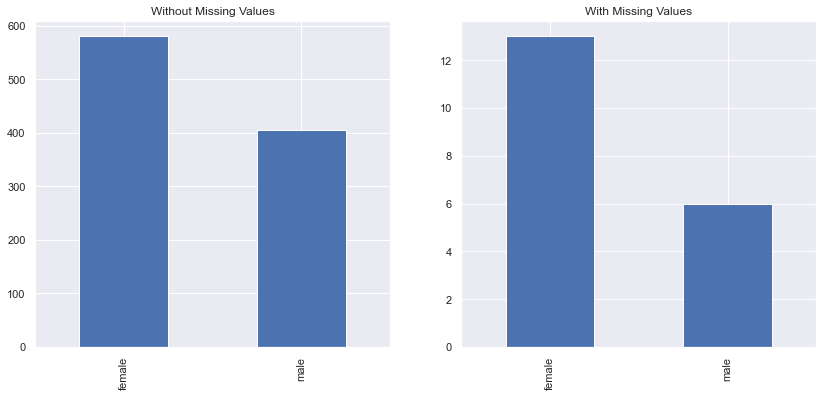

p-value of Chi_squared test: 0.5472167199163878
- - - - - - - - - - - - divider - - - - - - - - - - - 


In [97]:
#Get the numerical attrbiutes from air_df
numerical_attributes = ['Weight']
categorical_attributes = ['Gender']
# create the boolean mask of missing values 
BM_MV = pre_process_df.Height.isna()
# loop through each numerical attribute and run the Diagnose_MV_Numerical()
for att in numerical_attributes:
    print('Diagnosis Analysis of Missing Values for {}:'.format(att))
    Diagnose_MV_Numerical(pre_process_df,att,BM_MV)
    print('- - - - - - - - - - - - divider - - - - - - - - - - - ')
    
for att in categorical_attributes:
    print('Diagnosis Analysis of Missing Values for {}:'.format(att))
    Diagnose_MV_Categorical(pre_process_df,att,BM_MV)
    print('- - - - - - - - - - - - divider - - - - - - - - - - - ')

Diagnosis Analysis of Missing Values for Weight:


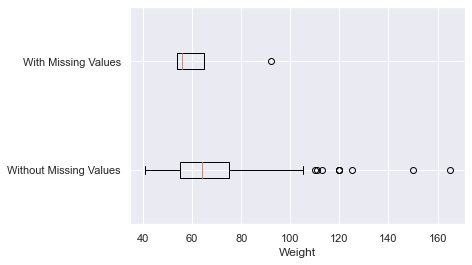

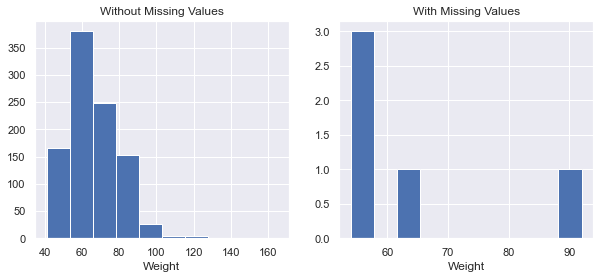

p-value of t-test: 0.7211552190644392
- - - - - - - - - - - - divider - - - - - - - - - - - 
Diagnosis Analysis of Missing Values for Height:


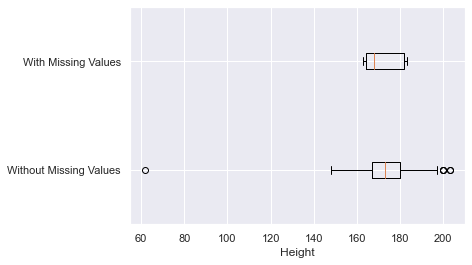

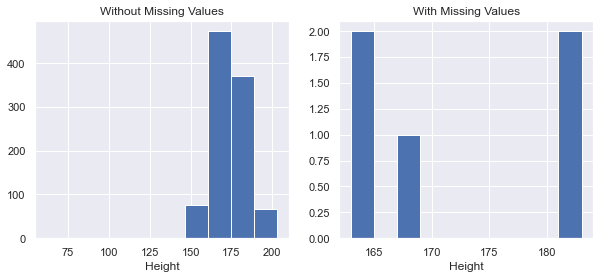

p-value of t-test: 0.7350966138879549
- - - - - - - - - - - - divider - - - - - - - - - - - 


In [98]:
#Get the numerical attrbiutes from air_df
numerical_attributes = ['Weight', 'Height']

# create the boolean mask of missing values 
BM_MV = pre_process_df.Gender.isna()
# loop through each numerical attribute and run the Diagnose_MV_Numerical()
for att in numerical_attributes:
    print('Diagnosis Analysis of Missing Values for {}:'.format(att))
    Diagnose_MV_Numerical(pre_process_df,att,BM_MV)
    print('- - - - - - - - - - - - divider - - - - - - - - - - - ')
    


The preceding reports indicate that the missing values (MVs) in Weight, Height, and Gender are of Missing Completely at Random type (MCAR). besides, the percentage of these missing values is negligible (<2%). The analytical tool(LinearRegression from sklearn) I'm going to use cannot inherently handle missing values so I need to either impute or drop the MVs. imputing might introduce bias as the attributes contain outliers (skewed). Therefore, the only doable option to deal with these missing values is dropping the data objects.


In [99]:
pre_process_df.dropna(inplace=True)

In [100]:
pre_process_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975 entries, 0 to 1009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  975 non-null    float64
 1   Height  975 non-null    float64
 2   Gender  975 non-null    object 
dtypes: float64(2), object(1)
memory usage: 30.5+ KB


## Detecting and dealing with outliers

Linear Regression (LR) is prone to outliers. I need to detect whether the data has univariate, bivariate, or multivariate outliers. In the following subsections, I will do this one step at a time.


### 1. Detecting univariate outliers and dealing with them

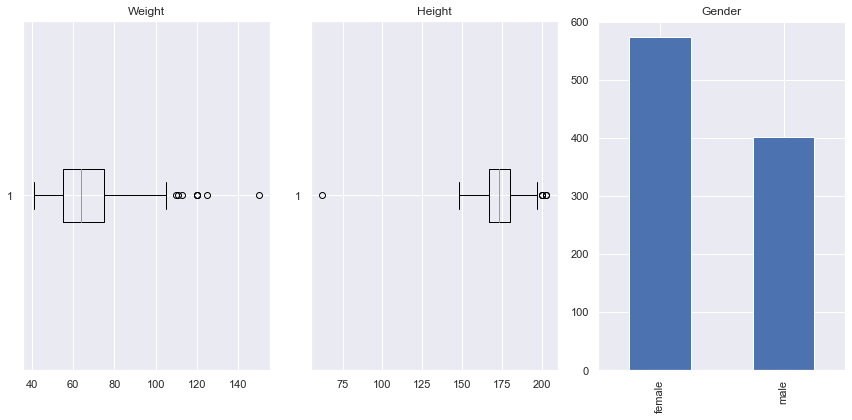

In [101]:
num_attributes = ['Weight', 'Height']
cat_attribues = ['Gender']
plt.figure(figsize=(12,6))
for i,att in enumerate(num_attributes):
    plt.subplot(1,3,i+1)
    plt.boxplot(pre_process_df[att], vert=False)
    plt.title(att)

    
plt.subplot(1,3,3)
pre_process_df.Gender.value_counts().plot.bar()
plt.tight_layout()
plt.title(cat_attribues[0])
plt.show()
    

we can see that both Height and Weight have outliers, but Gender does not. So, before moving on to the LR analysis, we need to deal with the outliers.
as suggest by the 'Dealing with outlier Chart' below, I can either; remove the data objects or replace them with their statistical upper cap or lower cap.

<img src="Dealing with outliers.png">

Since the data objects are univariate outliers, it is better to use the second approach, as replacing the statistical upper or the lower cap will help to keep the data objects and at the same time mitigate the negative effect of the data object with the outliers.

On the other hand—and this also applies generally—when the data objects are **bivariate or multivariate outliers**, **it would be better to remove them**. This is because these outliers will not allow the regression model to capture the patterns among the non-outlier data objects. In the **special case of bivariate outliers** whereby the pair of attributes is **categorical-numerical**, it might also be **sensible** to replace the outlier values with **the upper or lower caps** of the specific population.

In [102]:
def calculate_upper_lower_cap(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_cap = Q3 + 1.5*IQR
    lower_cup = Q1 - 1.5*IQR
    return upper_cap, lower_cup

def replace_upper_cap(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_cap = Q3 + 1.5*IQR
    BM = data[col] > upper_cap
    data.loc[data[BM].index, col] = upper_cap
    return data

def replace_lower_cap(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_cap = Q1 - 1.5*IQR
    BM = data[col] < lower_cap
    data.loc[data[BM].index, col] = lower_cap
    

In [103]:
replace_upper_cap(pre_process_df, 'Weight')
replace_lower_cap(pre_process_df,'Height')
replace_upper_cap(pre_process_df, 'Height')

,Weight,Height,Gender
0,48.0,163.0,female
1,58.0,163.0,female
2,67.0,176.0,female
3,59.0,172.0,female
4,59.0,170.0,female
...,...,...,...
1005,57.0,164.0,female
1006,80.0,183.0,male
1007,75.0,173.0,female
1008,58.0,173.0,female


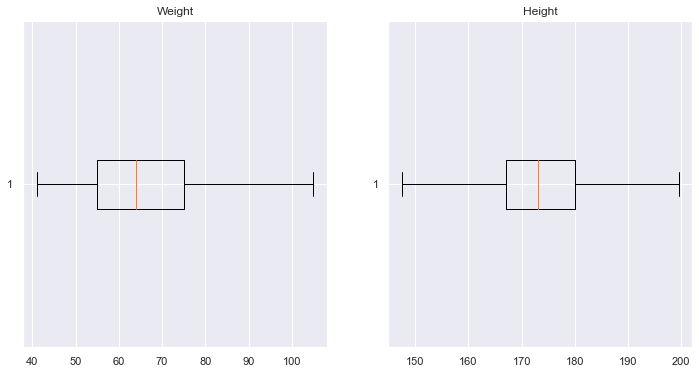

In [104]:
num_attributes = ['Weight', 'Height']

plt.figure(figsize=(12,6))
for i,att in enumerate(num_attributes):
    plt.subplot(1,2,i+1)
    plt.boxplot(pre_process_df[att], vert=False)
    plt.title(att)


### 2. Detecting bivariate outliers and dealing with them

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 864x576 with 0 Axes>

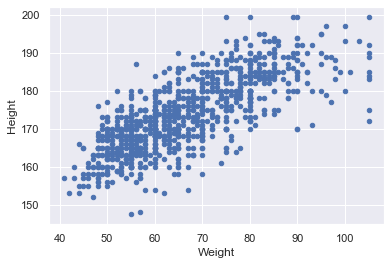

In [105]:
# Height and Weight
plt.figure(figsize=(12,8))
pre_process_df.plot.scatter(x='Weight', y='Height')
plt.show()

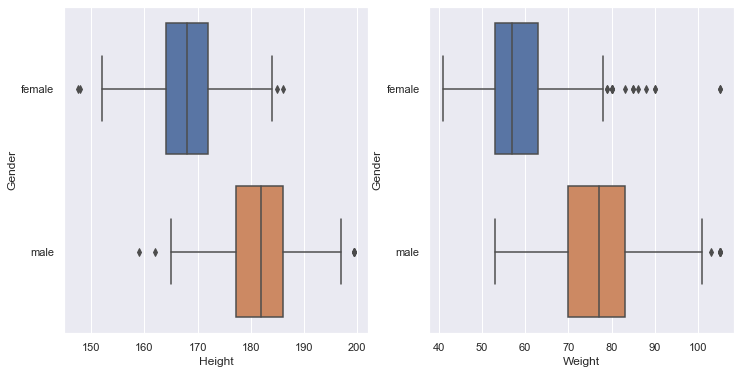

In [106]:
# Detecting bivariate outliers between :
# (Height and Gender) and  (Weight and Gender)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(x=pre_process_df.Height, y=pre_process_df.Gender)
plt.subplot(1,2,2)
sns.boxplot(x=pre_process_df.Weight, y=pre_process_df.Gender)
plt.show()

As these outliers are **bivariate** in a pair of **categorical-numerical** attributes, I will be replacing them with the specific population's upper or lower caps.


In [107]:
for poss in pre_process_df.Gender.unique():
    # poss either 'female' or 'male'
    BM = pre_process_df.Gender == poss
    
    # create 'on the fly' dataframe
    wdf = pre_process_df[BM]
    
    # calculate upper_cap and lower_ca^p
    upper_cap , lower_cap = calculate_upper_lower_cap(wdf, 'Height')
    
    # replace higher outlier with upper_cap
    BM = wdf.Height > upper_cap
    pre_process_df.loc[wdf[BM].index, 'Height'] = upper_cap
    # replace lower outliers with lower_cap
    BM = wdf.Height < lower_cap
    pre_process_df.loc[wdf[BM].index, 'Height'] = lower_cap
    

In [108]:
for poss in pre_process_df.Gender.unique():
    # poss either 'female' or 'male'
    BM = pre_process_df.Gender == poss
    
    # create 'on the fly' dataframe
    wdf = pre_process_df[BM]
    
    # calculate upper_cap and lower_ca^p
    upper_cap , lower_cap = calculate_upper_lower_cap(wdf, 'Weight')
    
    # replace higher outlier with upper_cap
    BM = wdf.Weight > upper_cap
    pre_process_df.loc[wdf[BM].index, 'Weight'] = upper_cap
    # replace lower outliers with lower_cap
    BM = wdf.Weight < lower_cap
    pre_process_df.loc[wdf[BM].index, 'Weight'] = lower_cap

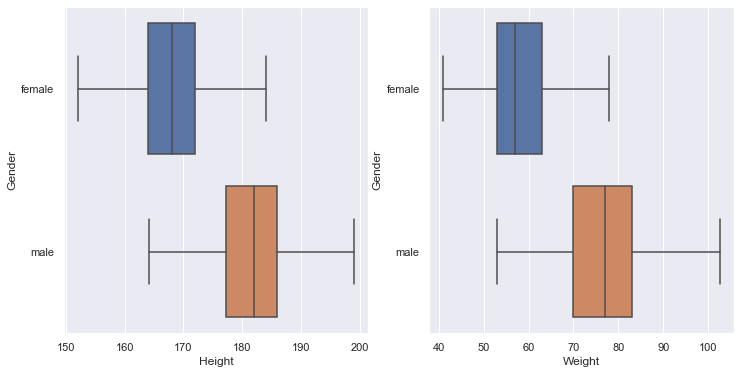

In [109]:
# Confirming bivariate outliers are replaced
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(x=pre_process_df.Height, y=pre_process_df.Gender)
plt.subplot(1,2,2)
sns.boxplot(x=pre_process_df.Weight, y=pre_process_df.Gender)
plt.show()

### 3. Detecting multivariate outliers and dealing with them

To detect multivariate outliers, the standard method is to use clustering analysis; however, when two of the three attributes are numerical and the other is categorical, we can do outlier detection using a specific visualization technique.


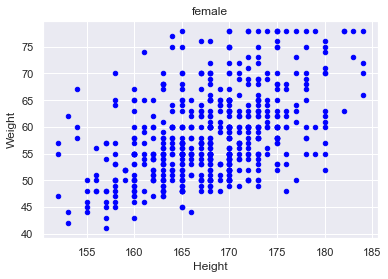

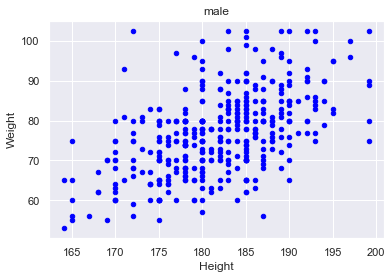

In [111]:
cat_attribute_poss = pre_process_df.Gender.unique()
for i,poss in enumerate(cat_attribute_poss):
    BM = pre_process_df.Gender == poss
    pre_process_df[BM].plot.scatter(x='Height',y='Weight', color='blue')
    plt.title(poss)
    plt.show()


Based on the preceding figure, we can conclude that there are no multivariate outliers in the data. If there were any, the only choice we would have would be to remove them, as outliers can negatively impact LR performance.

**replacing the outliers with upper and lower caps is not an option for multivariate outliers.**

## Applying Linear Regression

Before applying LR, I need to encode the Gender attribute.

In [113]:
dic = {'male': 1, 'female': 0}
pre_process_df.Gender.replace(dic, inplace=True)

In [115]:
pre_process_df.Gender.value_counts()

0    573
1    402
Name: Gender, dtype: int64

In [116]:
from sklearn.linear_model import LinearRegression

X = ['Height','Gender']
y = 'Weight'

data_X = pre_process_df[X]
data_y = pre_process_df[y]

lm = LinearRegression()
lm.fit(data_X, data_y)


LinearRegression()

In [117]:
print('intercept (b0) ', lm.intercept_)
coef_names = ['b1','b2']
print(pd.DataFrame({'Predictor': data_X.columns,
                    'coefficient Name':coef_names, 
                    'coefficient Value': lm.coef_}))


intercept (b0)  -59.70584266595988
  Predictor coefficient Name  coefficient Value
0    Height               b1           0.704025
1    Gender               b2           8.602017


In [130]:
lm.predict(np.array([[189, 0]]))

array([73.35484])

## Applying MLP

In [118]:
select_attributes = ['Weight','Height','Gender']
pre_process_df = pd.DataFrame(response_df[select_attributes])
pre_process_df.dropna(inplace=True)
pre_process_df.Gender.replace({'male':0,'female':1},inplace=True)

In [119]:
from sklearn.neural_network import MLPRegressor

X = ['Height','Gender']
y = 'Weight'

data_X = pre_process_df[X]
data_y = pre_process_df[y]

mlp = MLPRegressor(hidden_layer_sizes=5, max_iter=3000)
mlp.fit(data_X, data_y)


MLPRegressor(hidden_layer_sizes=5, max_iter=3000)

In [120]:
newData = pd.DataFrame({'Height':189.5,'Gender':0},
                       index=[0])
mlp.predict(newData)


array([80.24421817])

## Example 2: Dealing with outliers when performing Clustering

The mayor of Chicago would like to assign 5 communication liaisons for the 77 communities in the cmmunity_df dataset. 

anaytica approach: employing K-Means clustering to group the communities into five groups and assigning the appropriate liaisons based on the characteristics of clustered groups.


In [138]:
community_df = pd.read_csv('chicago_population.csv')
community_df.head()

,name,population,income,latino,black,white,asian,other
0,Rogers Park,54991,39482,0.244,0.263,0.393,0.064,0.036
1,West Ridge,71942,47323,0.204,0.111,0.427,0.225,0.032
2,Uptown,56362,40324,0.142,0.200,0.516,0.114,0.028
3,Lincoln Square,39493,57749,0.191,0.038,0.631,0.111,0.029
4,North Center,31867,81524,0.136,0.023,0.773,0.045,0.022


In [139]:
community_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        77 non-null     object 
 1   population  77 non-null     int64  
 2   income      77 non-null     int64  
 3   latino      77 non-null     float64
 4   black       77 non-null     float64
 5   white       77 non-null     float64
 6   asian       77 non-null     float64
 7   other       77 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 4.9+ KB


No missing values

## Checking if the sum of percentages is 1

In [151]:
df = community_df.loc[:,'latino':'other'].sum(axis=1)


In [155]:
def check_percentage(n):
    if n<=1.01 and n>=0.99:
        return True
    else:
        return False

In [157]:
BM = df.apply(check_percentage)
community_df[~BM]

,name,population,income,latino,black,white,asian,other


data is good, Nothing to worry about

## Detecting outliers

### 1 detecting univariate outliers and dealing with them

In [158]:
community_df.columns

Index(['name', 'population', 'income', 'latino', 'black', 'white', 'asian',
       'other'],
      dtype='object')

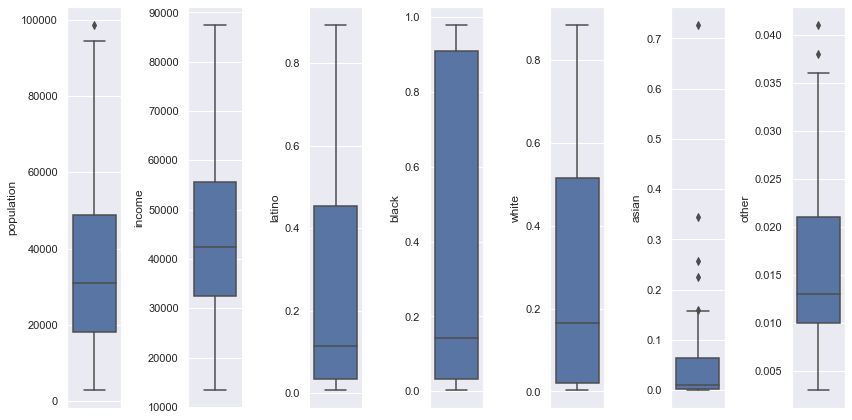

In [159]:
numerical_attributes = ['population', 'income', 'latino', 'black', 'white', 'asian','other']

plt.figure(figsize=(12,6))
for i,att in enumerate(numerical_attributes):
    plt.subplot(1,len(numerical_attributes),i+1)
    sns.boxplot(y=community_df[att])
    
plt.tight_layout()
plt.show()
    

As we are using K-Means to cluster the communities into five homogenous groups to assign communication liaisons, the best way to deal with the outliers is to replace them with statistical lower or upper caps.

if we were to perform a clustering analysis to find out the inherent pattern in the data, then the best way to deal with the outliers is to do nothing.


In [160]:
candidate_atts = ['population','asian','other']

for att in candidate_atts:
    replace_lower_cap(community_df, att)
    replace_upper_cap(community_df, att)

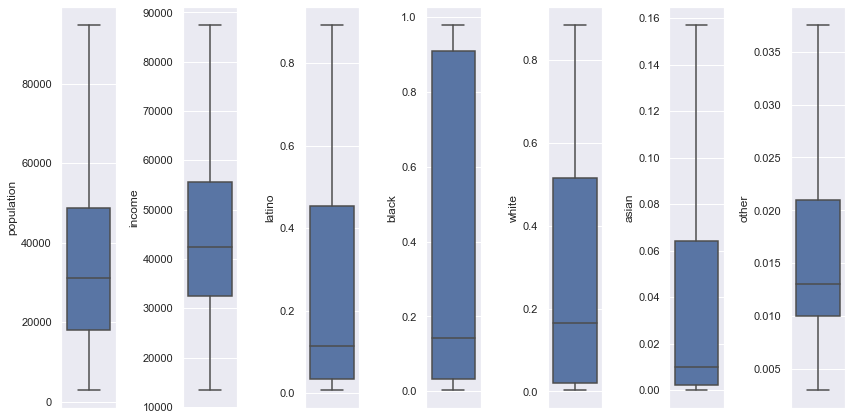

In [161]:
numerical_attributes = ['population', 'income', 'latino', 'black', 'white', 'asian','other']

plt.figure(figsize=(12,6))
for i,att in enumerate(numerical_attributes):
    plt.subplot(1,len(numerical_attributes),i+1)
    sns.boxplot(y=community_df[att])
    
plt.tight_layout()
plt.show()

### 2 Detecting bivariate and multivariate outliers and dealing with them


It adds no value to detect bivariate and multivariate outliers as the only strategy I can use for them at this stage is to do nothing—we cannot replace them with the upper or lower caps as there is more than one numerical attribute; neither can I remove the data objects as we need all the data objects to be in at least one of the clusters. Therefore, the current state of community_df is the best possible it can be for the clustering analysis. As the data preprocessing is complete, the only remaining step in this example is to perform clustering.


In [162]:
from sklearn.cluster import KMeans
dimensions = ['population', 'income', 'latino', 'black', 'white', 'asian','other']
Xs = community_df[dimensions]
# standarize the data
Xs = (Xs - Xs.min())/(Xs.max()-Xs.min())
kmeans = KMeans(n_clusters=5)
kmeans.fit(Xs)

KMeans(n_clusters=5)

In [165]:
for i in range(5):
    BM = kmeans.labels_==i
    print('Cluster {}: {}'.format(i,community_df[BM].name.values))

Cluster 0: ['North Center' 'Lake View' 'Lincoln Park' 'Near North Side' 'Edison Park'
 'Norwood Park' 'Jefferson Park' 'Forest Glen' 'Portage Park' 'Dunning'
 'West Town' 'Garfield Ridge' 'Beverly' 'Mount Greenwood' "O'Hare"]
Cluster 1: ['Austin' 'West Garfield Park' 'East Garfield Park' 'North Lawndale'
 'Oakland' 'Fuller Park' 'Grand Boulevard' 'Kenwood' 'Washington Park'
 'Woodlawn' 'South Shore' 'Chatham' 'Avalon Park' 'South Chicago'
 'Burnside' 'Calumet Heights' 'Roseland' 'Pullman' 'South Deering'
 'West Pullman' 'Riverdale' 'West Englewood' 'Englewood'
 'Greater Grand Crossing' 'Auburn Gresham' 'Washington Heights'
 'Morgan Park']
Cluster 2: ['Montclare' 'Belmont Cragin' 'Hermosa' 'Avondale' 'Logan Square'
 'Humboldt Park' 'South Lawndale' 'Lower West Side' 'East Side'
 'Hegewisch' 'Archer Heights' 'Brighton Park' 'New City' 'West Elsdon'
 'Gage Park' 'Clearing' 'West Lawn' 'Chicago Lawn' 'Ashburn']
Cluster 3: ['Rogers Park' 'West Ridge' 'Uptown' 'Lincoln Square' 'North Park'
 

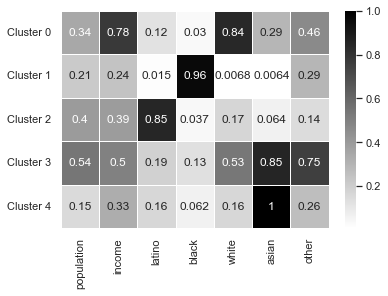

In [166]:
# centroid analysis

clusters = ['Cluster {}'.format(i) for i in range(5)]

Centroids = pd.DataFrame(0.0, index =  clusters,
                        columns = Xs.columns)
for i,clst in enumerate(clusters):
    BM = kmeans.labels_==i
    Centroids.loc[clst] = Xs[BM].median(axis=0)

sns.heatmap(Centroids, linewidths=.5, annot=True, 
                    cmap='binary')
plt.show()

We can see in the preceding figure that the communities in each cluster are distinctively different, and this result will be tremendously helpful in assigning communication liaisons


# END